# Option Pricing Applications
An interactive presentation using Python

manos.venardos@gmail.com

# Agenda

- Put-Call Parity
- No-arbitrage interval
- Risk Neutral Distribution
- Black Scholes Model
- Implied Volatility & Parameterisation
- Implied vs Realised Volatility

Using many standard 3rd party libraries, and purpose-built analytics.

In [2]:
#Numerics & Analytics
import datetime
import numpy as np
import pandas as pd
from pandas_datareader import data
from pandas.plotting import autocorrelation_plot
from scipy import stats, optimize
from scipy.stats import norm
from scipy.signal import savgol_filter

#Graphs & widgets
import matplotlib.pyplot as plt
from bokeh.plotting import figure
from bokeh.io import show, output_notebook, push_notebook
from bokeh.layouts import row, column, gridplot
from bokeh.models import ColumnDataSource, Span, HoverTool, CrosshairTool
from bokeh.models.glyphs import Patch
from bokeh.models.annotations import Title
from ipywidgets import interact, interactive, interactive_output, Button, HBox, VBox, FloatSlider, Checkbox, link

#Option Pricing
import black_scholes as bs_model
import implied_vol as iv_model

In [3]:
%matplotlib inline

# Quiz 1: Forward Price

A very promising stock trades at $\$100$ and pays no dividends. Equity analysts expect the price to grow by $20\%$ per annum. Interest rates are $5\%$.

***"We commit to exchange the stock for $\$F$ in 1 year from today"***. 

What value of $F$ makes this contract have zero value today?

1. $\$ 100$
2. $\$ 120$
3. $\$ 105$
4. Information on volatility is needed

# Models
We assume a financial market where there are no arbitrage opportunities and 2 underlying assets
- A riskless money-market account $M$, accruing the short rate of interest $r$
- A risky asset with price process $S$, possibly delivering yield, dividend and coupon streams $C$

In this setup, there exists a risk-neutral probability measure $Q$, equivalent to the real world measure $P$, under which the total financial gains $G^S$, deflated by $M$ are a martingale 

$$M_t^{-1}G_t^S = E^Q_t[M_T^{-1}G_T^S|I_t]$$

where $I_t$ denotes the available information at time $t$. 

Expected gains equal the riskless rate of return $r$, whereas unexpected gains are model-dependent.

We will frequently make simplifying assumptions, including 
- Interest rates are zero or deterministic (or operating under a forward measure)
- There are are no interim payment streams associated with the risky asset (no yields / dividends  / coupons), in which case $G^S = S$

Model complexity varies significantly and a basic taxonomy is as follows

|  Discrete Time & State | Continuous Time & Continuous Paths  | Continuous Time & Discontinuous Paths |
|:---|:---|:---|
|  Binomial Tree | Black Scholes  | Merton  |
| Trinomial Tree | Local & Stochastic Volatility| Jump Diffusions |
| etc. | etc. | etc. |

Many models focus on the dynamics of the log-price $X_t = \ln S_t$.

# Derivative Contracts
A derivative security $V$ is a contingent future payout that is linked to the price of the underlying security $S$. 

There is a big universe of such payouts and we broadly classify them as follows

| Terminal | Path Dependent|
|:---|:---|
|Cashflow| Barrier option|
|Forward | Asian option|
|Call/Put | Forward start option|
|Log-contract | Variance Swap |
| etc. | etc. |

Since derivatives are financial assets, it follows that for contracts without interim payment streams 

$$V_t = M_t E_t^Q[M_T^{-1}V_T|It]$$ 

By setting $V_T = 1$, one obtains the price of a fixed cashflow, which we denote by

$$PV_t(T) = M_t E_t^Q[M_T^{-1}|It]$$


## Forward Contract
The Forward contract is the ***obligation*** at maturity $T$ to exchange 1 unit of $S$ for a pre-agreed price $K$. Forward contracts trade at inception at a zero price, by an appropriate choice $K^*$
$$M_t E^Q_t[M_T^{-1}(S_T-K^*) |I_t] = 0 \Rightarrow K^* = \frac{M_t E_t^Q[M_T^{-1} S_T|I_t]}{PV_t(T)}$$
a.k.a. the ***Forward Price*** of the asset, denoted by $F_t(T)$.

The forward price depends on the asset's interim payment streams. A few interesting special cases are
- When rates are zero or deterministic $K^* = E_t^Q[S_T|I_t]$
- When the asset makes no interim payments (rates can be arbitrary) $K^* = PV_t^{-1}(T) S_t$ 
- When rates and interim payments are zero $K^* = S_t$ 

and, therefore, the forward price is model-free in many simple cases.

## European Option
The European Call (Put) contracts give the holder the ***right***, but not the obligation, to buy (sell) the underlying asset $S$ at expiry $T$ for a pre-agreed price $K$. Their payouts are

\begin{eqnarray}
C(S_T, T) & = & \max (S_T-K,0) \\
P(S_T, T) & = & \max (K-S_T,0)
\end{eqnarray}

and their prices are therefore 

\begin{eqnarray}
c(S_t,t) & = & M_t E_t^Q[M_T^{-1}C(S_T,T)] \\
p(S_t,t) & = & M_t E_t^Q[M_T^{-1}P(S_T,T)]
\end{eqnarray}

# Put-Call Parity

The ***Put-Call Parity*** suggests that for a given $K$ there is a payoff relationship at expiry $T$, which then translates to a relationship between prices at $t$

\begin{eqnarray}
C - P & = & S_T - K \\
c - p & = & PV_t(T)(F_t(T) - K)
\end{eqnarray}

Put-call parity can be tested by fitting a linear in strike regression model using OLS

$$c_i - p_i = \alpha + \beta K_i + \epsilon_i$$

from which we can also imply the discount factor and the asset's forward price

\begin{eqnarray}
PV_t(T) & = & -\hat{\beta} \\
F_t(T) & = & -\frac{\hat{\alpha}}{\hat{\beta}}
\end{eqnarray}

We now load a data set of SPX options expiring on 20/12/2019, as observed on 26/12/2018.

In [4]:
#Load data from a flat file
undl = '^GSPC'
as_of = datetime.datetime(2018, 12, 26).date()
expiry = datetime.datetime(2019, 12, 20).date()
filename = '_'.join([undl, as_of.strftime("%Y%m%d"), expiry.strftime("%Y%m%d")]) + '.csv'
print('Filename: ' + filename)

Filename: ^GSPC_20181226_20191220.csv


In [5]:
#Load all data, select subset for which both calls and puts are quoted
df = pd.read_csv(filename).sort_values('Strike')
c_strikes = df[df['Type'] == 'CALL']['Strike']
p_strikes = df[df['Type'] == 'PUT']['Strike']
strikes = np.sort(np.intersect1d(c_strikes, p_strikes)) 
df_common = df[df['Strike'].isin(strikes)].sort_values('Strike')

df_common[['Strike', 'Type', 'Midpoint', 'Bid', 'Ask', 'Volume']].head(8)

,Strike,Type,Midpoint,Bid,Ask,Volume
0,100,CALL,2242.80,2239.20,2246.40,1.0
113,100,PUT,0.08,0.05,0.10,530.0
1,200,CALL,2145.65,2142.10,2149.20,100.0
114,200,PUT,0.08,0.05,0.10,420.0
2,300,CALL,2048.35,2044.80,2051.90,118.0
115,300,PUT,0.10,0.05,0.15,400.0
3,400,CALL,1951.15,1947.60,1954.70,10.0
116,400,PUT,0.13,0.05,0.20,10.0


We imply the SPX forward price and USD discount factor by running an OLS regression on put-call parity. 
We also test the stability of the estimates by expanding the sample outwards from the ATM region.

In [6]:
#Create the put-call parity relationship and fit with OLS a linear model in Strike
pc_parity = df_common[df_common['Type'] == 'CALL']['Midpoint'].values - df_common[df_common['Type'] == 'PUT']['Midpoint'].values
b, a, r_value, p_value, std_err = stats.linregress(strikes, pc_parity)
pv_hat = -b
fwd_hat = -a/b

#Also estimate coefficients starting from ATM and expanding outwards, to test the stability of estimation
atm_idx = np.abs(pc_parity - 0.0).argmin()
atm_strike = strikes[atm_idx]
intervals = np.arange(5, atm_idx)
alphas, betas = [], []
for i in intervals:
    bb, aa, rr, pp, ss = stats.linregress(strikes[atm_idx - i:atm_idx + i], pc_parity[atm_idx - i:atm_idx + i])
    alphas.append(aa)
    betas.append(bb)

alphas = np.asarray(alphas)    
betas = np.asarray(betas)    
    
pvs_hat = -betas
fwds_hat = -alphas / betas

In [7]:
def plot_put_call_parity(undl, expiry, strikes, parity, A, B, fwd_had, pv_hat, intervals, fwd_hats, pv_hats):
    fig1 = plt.figure(figsize=(20, 10))
    fig1.suptitle('Put-Call parity for ' + undl + ', expiry ' + expiry.strftime("%d-%b-%Y"), fontsize=16)
    gs1 = fig1.add_gridspec(2, 2)

    ax1_1 = fig1.add_subplot(gs1[0:2,0])
    ax1_1.plot(strikes, parity, label = 'Empirical', ls='', marker = 'o', color = 'b')
    ax1_1.plot(strikes, A + B * strikes, label = 'OLS fit: ' + 'p-c='+'{:.2f}'.format(A)+'{:.2f}'.format(B)+'K', color = 'r')
    ax1_1.axvline(x = fwd_hat, label = 'Implied Fwd', color = 'k', ls = '--')
    ax1_1.plot([strikes[0], strikes[-1]], [0.0]*2, color = 'k')
    ax1_1.set_xlabel('Strike')
    ax1_1.set_ylabel('Put - Call')
    ax1_1.legend()

    ax1_2 = fig1.add_subplot(gs1[0:1,1])
    ax1_2.plot(intervals, fwd_hats, ls='', marker ='o')
    ax1_2.title.set_text(r'$-\hat{\alpha_n} / \hat{\beta_n}$')
    ax1_2.set_xlabel('Sample size')
    ax1_2.set_ylabel('Forward')

    ax1_3 = fig1.add_subplot(gs1[1:2,1])
    ax1_3.plot(intervals, pv_hats, ls='', marker ='o')
    ax1_3.title.set_text(r'$-\hat{\beta_n}$')
    ax1_3.set_xlabel('Sample size')
    ax1_3.set_ylabel('PV')

    # fig1.tight_layout()
    # fig1.subplots_adjust(top = 0.92)
    plt.show()    

The plots suggest that put-call parity holds consistently across the strike chain.

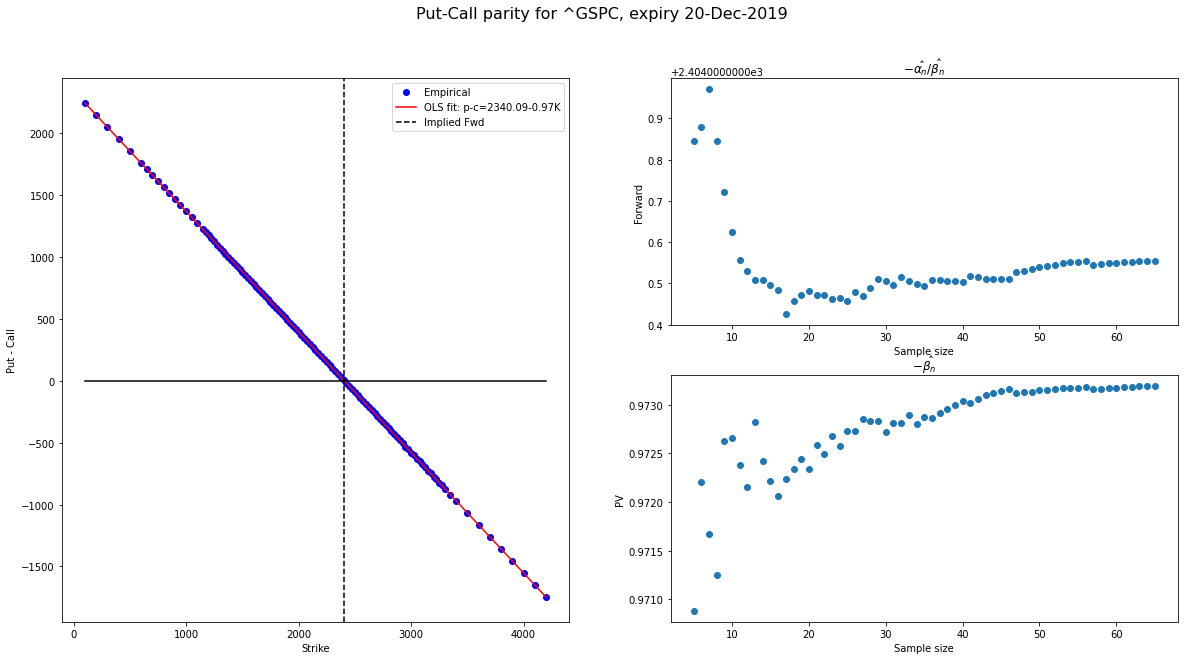

In [8]:
plot_put_call_parity(undl, expiry, strikes, pc_parity, a, b, fwd_hat, pv_hat, intervals, fwds_hat, pvs_hat)

# No-Arbitrage Interval

Unlike the Forward contract, there isn't a model-free price for a European option. 

Instead, only a range of acceptable prices can be obtained. 

For an asset without interim payments these are

\begin{eqnarray}
\max (S_t - PV_t(T) K, 0) & \leq c \leq & S_t \\
\max (PV_t(T) K - S_t, 0) & \leq p \leq & PV_t(T) K
\end{eqnarray}

These are referred to as the ***no-arbitrage intervals*** for European options, and are actually very wide.

To derive these results, consider the two basic arguments

- Starting with put options, the payout at expiry is capped $P\leq K$, and therefore so is the price $p \leq PV_t(T) K$. Invoking put-call parity implies $C \leq S_T$ and therefore $c \leq S_t$

- Consider 2 portfolios at inception $\Pi_1 = c + PV_t(T) K$ and $\Pi_2 = S_t$. At expiry, $\Pi_1 = \max(S_T - K,0) +K \geq S_T = \Pi_2$. Hence $c \geq \max(S_t - PV_t(T) K,0)$

Note that the lower bounds differ from the intrinsic value of the options due to the $PV$ term.

We now calculate the intrinsic value and no arbitrage intervals using the analytics libraries.

These methods cope with vector arguments so we calculate these across a range of spot prices.

In [9]:
#Compute the no-arbitrage intervals for ATM call and put, across different spot prices
PV = 0.9
strike = 100.0
spots = np.arange(00.0, 200.0, 1.0)

c_intrinsic = bs_model.option_intrinsic_value(spots, strike, bs_model.CALL)
c_min, c_max = bs_model.option_price_interval(spots / PV, PV, strike, bs_model.CALL)

p_intrinsic = bs_model.option_intrinsic_value(spots, strike, bs_model.PUT)
p_min, p_max = bs_model.option_price_interval(spots / PV, PV, strike, bs_model.PUT)

In [12]:
def plot_range_and_intrinsic(spots, strikes, pv, c_int, c_min, c_max, p_int, p_min, p_max):
    fig2, (ax2_1, ax2_2) = plt.subplots(1, 2, figsize=(20,5))
    fig2.suptitle('No-Arbitrage Interval', fontsize=16)

    ax2_1.plot(spots, c_int, label = 'Intrinsic', color = 'k', ls = '--')
    ax2_1.plot(spots, c_min, label = 'Lower bound', color = 'r')
    ax2_1.plot(spots, c_max, label = 'Upper bound', color = 'b')
    ax2_1.fill_between(spots, c_min, c_max, color='grey', alpha=0.3)
    ax2_1.title.set_text('European Call, Strike ' + '{:.0f}'.format(strikes) + ', PV ' + '{:.2f}'.format(pv))
    ax2_1.set_xlabel('Spot')
    ax2_1.set_ylabel('Price')
    ax2_1.legend()

    ax2_2.plot(spots, p_int, label = 'Intrinsic', color = 'k', ls = '--')
    ax2_2.plot(spots, p_min, label = 'Lower bound', color = 'r')
    ax2_2.plot(spots, p_max, label = 'Upper bound', color = 'b')
    ax2_2.fill_between(spots, p_min, p_max, color='grey', alpha=0.3)
    ax2_2.title.set_text('European Put, Strike ' + '{:.0f}'.format(strikes) + ', PV ' + '{:.2f}'.format(pv))
    ax2_2.set_xlabel('Spot')
    ax2_2.set_ylabel('Price')
    ax2_2.legend()

    plt.show()

The plots show the intrinsic value and no-arbitrage intervals for call and put options across  spot prices.

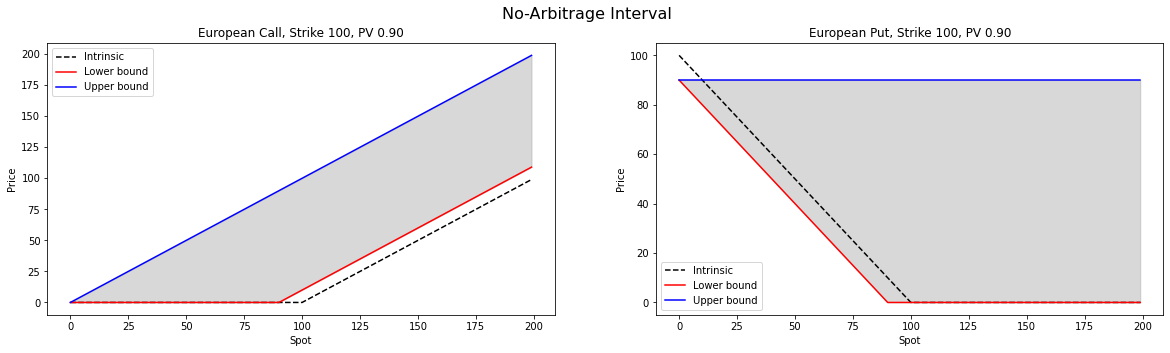

In [13]:
plot_range_and_intrinsic(spots, strike, PV, c_intrinsic, c_min, c_max, p_intrinsic, p_min, p_max)

In the absence of interim payments
- European call prices always trade above their intrinsic value
- European put prices can trade below their intrinsic value

# Option Strategies
In this section we discuss basic combinations of call and put options and conclude that they are also expected to trade within certain no-arbitrage intervals. 

Hence, no-arbitrage implies not only conditions for each and every call and put option price individually, but also conditions across combinations of option prices.

## Put Spread

The ***Put Spread*** involves long positions in a put with strike $K_2$ and equal and short positions in a put with strike $K_1$, all expiring at time $T$ and with $K_1<K_2$. For convenience we chose the position to be $(K_2 - K_1)^{-1}$, so the payoff becomes

$$PS(K_1, K_2) = \frac{P(K_2) - P(K_1)}{K_2-K_1}$$

The no-arbitrage interval associated with this strategy is

\begin{eqnarray}
0 & \leq PS  \leq & < 1 \\
0 & \leq ps \leq & PV_t(T)
\end{eqnarray}

for all strike pairs.

## Call Spread

We define the ***Call Spread*** as 

$$
CS(K_1, K_2) = \frac{C(K_1) - C(K_2)}{K_2 - K_1}
$$

which is also bound by the no-arbitrage interval

\begin{eqnarray}
0 & \leq CS  \leq & < 1 \\
0 & \leq cs \leq & PV_t(T)
\end{eqnarray}

for all strike pairs.

From these we deduce the spread parity relationship

\begin{eqnarray}
CS + PS & = & 1 \\
cs + ps & = & PV_t(T)
\end{eqnarray}

which follows due to the order of options in the numerator in the 2 spread positions.

## Butterfly Spread
The ***Butterfly Spread*** involves equal and long positons in a put with strikes $K_1, K_3$ and twice as many short positions in a put with strike $K_2$, all expiring at time $T$ and with $K_1<K_2<K_3$. Alternatively, it can be constructed with call options instead. For convenience we chose the position to be $((K_3-K_2)(K_2 - K_1))^{-1}$, so the payoff becomes

$$
BS(K_1, K_2, K_3) = \frac{P(K_1) - 2 P(K_2) + P(K_3)}{(K_3-K_2)(K_2-K_1)} = \frac{C(K_1) - 2 C(K_2) + C(K_3)}{(K_3-K_2)(K_2-K_1)} 
$$

The no-arbitrage interval associated with this strategy is

\begin{eqnarray}
0 & \leq & BS \\
0 & \leq & bs
\end{eqnarray}

for all strike triplets.

We now calculate the payoffs as a function of the spot price at expiry for the 3 option strategies.

In [14]:
#Calculate the payoff at maturity for a callspread, putspread and butterfly spread
strike1 = 75.0
strike2 = 100.0
strike3 = 125.0

c_spread = (bs_model.option_intrinsic_value(spots, strike1, bs_model.CALL) - 
            bs_model.option_intrinsic_value(spots, strike3, bs_model.CALL)) / (strike3 - strike1)

p_spread = (bs_model.option_intrinsic_value(spots, strike3, bs_model.PUT) - 
            bs_model.option_intrinsic_value(spots, strike1, bs_model.PUT)) / (strike3 - strike1)

b_spread = (bs_model.option_intrinsic_value(spots, strike1, bs_model.CALL) - 
            2.0 * bs_model.option_intrinsic_value(spots, strike2, bs_model.CALL) + 
            bs_model.option_intrinsic_value(spots, strike3, bs_model.CALL)) / ((strike3 - strike2)*(strike2 - strike1))

In [15]:
def plot_strategies_payoffs(spots, strike1, strike2, strike3, p_spread, c_spread, b_spread):
    fig3, (ax3_1, ax3_2) = plt.subplots(1, 2, figsize=(20,5))
    fig3.suptitle('Option Strategies Payouts', fontsize=16)

    ax3_1.plot(spots, p_spread, label = 'Put Spread')
    ax3_1.plot(spots, c_spread, label = 'Call Spread')
    ax3_1.title.set_text('Call & Put Spread, Strikes: ' + '{:.0f}'.format(strike1) + ', ' + '{:.0f}'.format(strike3))
    ax3_1.set_xlabel('Spot')
    ax3_1.set_ylabel('Price')
    ax3_1.legend()

    ax3_2.plot(spots, b_spread)
    ax3_2.title.set_text('Butterfly Spread, Strikes: ' + '{:.0f}'.format(strike1) + ', ' + '{:.0f}'.format(strike2) + ', ' + '{:.0f}'.format(strike3))
    ax3_2.set_xlabel('Spot')
    ax3_2.set_ylabel('Price')

    plt.show()

And plot their payoff as a function of the spot price at expiry.

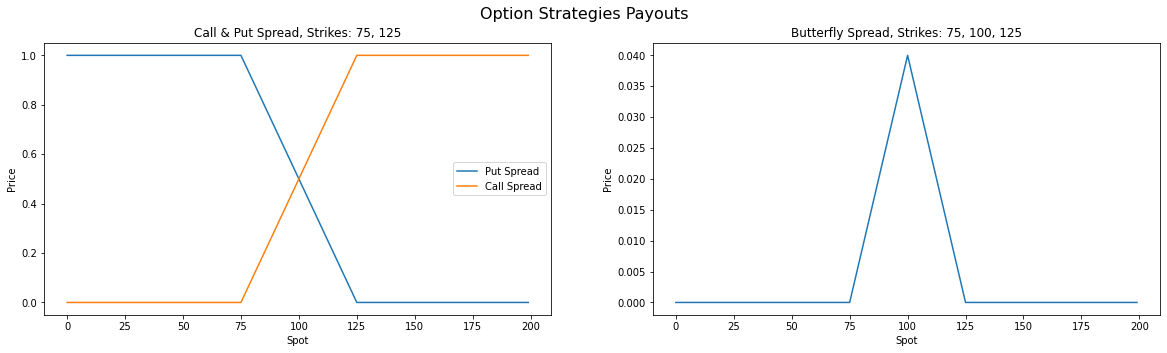

In [16]:
plot_strategies_payoffs(spots, strike1, strike2, strike3, p_spread, c_spread, b_spread)

# Quiz 2: Arrow Securities

Prices in 1 year randomly take any value from a known set of values $S_1, ..., S_N$. The state space is discrete.

Consider the strike triplet $K_1 = S_{n-1} < K_2 = S_n < K_3 = S_{n+1}$ used to construct the call / put / buttefly spread strategies for some $n \in {2,..,N-1}$.

Select the incorrect statement

1. A butterfly-spread is conceptually similar to an Arrow security paying $\$1$ when $S = K_2$.

2. A call-spread is conceptually similar to the sum of Arrow securities paying $\$1$ when $S = S_i, i \leq n$.

3. A put-spread is conceptually similar to a sum of Arrow securities paying $\$1$ when $S = S_i, i \leq n$.

4. In continuous state space, the equivalent of an Arrow security is the Dirac delta function $\delta(S-K_2)$.

# Risk Neutral Distribution
One can imply non-parametrically the risk neutral measure $Q$ from market quotes directly. Assume one observes the continuum of call & put prices across strikes for a given expiry. Expressing the expected value as an integration operator over the risk neutral density $q$ and assuming sufficient regularity, yields

\begin{eqnarray}
p(K) & = & PV \int_0^{\infty} \max(K-S,0) q(S) dS = \int_0^K (K-S) q(S)dS \\
\frac{\partial p}{\partial K}& = & PV \int_0^K q(S) dS = PV Q(K) \\
\frac{\partial^2 p}{\partial K^2}& = & PV q(K)
\end{eqnarray}

where $Q(x) = \Pr^Q(S_T \leq x)$ and $q(x) = Q'(x)$. Effectively, the first and second derivatives of put prices w.r.t. strike reveal the market's risk-neutral probability distribution and density functions respectively. 

We use the quoted call & put prices to construct the call, put and buttefly spreads since

\begin{eqnarray}
\lim_{K_1 \rightarrow K_2} ps(K_1, K_2) & = & \frac{\partial p}{\partial K} \\
\lim_{K_1 \rightarrow K_2} cs(K_1, K_2) & = & PV - \frac{\partial p}{\partial K} \\
\lim_{K_1 \rightarrow K_2 \rightarrow K_3} bs(K_1, K_2, K_3) & = & \frac{\partial^2 p}{\partial K^2}
\end{eqnarray}

It is typical to use OTM options as they are more liquid. Practical problems include
- Strike grids may be sparse and not uniform
- Chosing between Last, Bid, Ask and constructed Mid quotes
- Price flooring i.e. very OTM options trading for a minimum premium, and never at zero
- Concatenating puts with calls around ATM may result in discontinuities and kinks

We now apply this technique on the observed SPX option chain. We also employ a smoother.

In [17]:
#Select OTM options
otm_puts = df[(df['Type'] == 'PUT') & (df['Strike'] <= atm_strike)]
otm_calls = df[(df['Type'] == 'CALL') & (df['Strike'] >= atm_strike)]

#Compute implied probability using putspreads and callspreads
prob_put_strikes = ((otm_puts['Strike'] + otm_puts['Strike'].shift(1)) / 2.0)[1:].values
prob_put = (1.0 / pv_hat)*(otm_puts['Midpoint'].diff() / otm_puts['Strike'].diff())[1:].values
prob_call_strikes = ((otm_calls['Strike'] + otm_calls['Strike'].shift(1)) / 2.0)[1:].values
prob_call = 1.0 + (1.0 / pv_hat)*(otm_calls['Midpoint'].diff() / otm_calls['Strike'].diff())[1:].values

prob_strikes = np.append(prob_put_strikes, prob_call_strikes)
prob = np.append(prob_put, prob_call)

#Also a smoothed version of probability
prob_hat = savgol_filter(prob, 51, 5) # window size 51, polynomial order 3

#Compute the implied density by butterfly spreads (or spreads of putspreads)
dens_strikes = (prob_strikes[1:] + prob_strikes[:-1]) / 2.0
dens = np.diff(prob) / np.diff(prob_strikes)

#And a smoothed version of the density
dens_hat = np.diff(prob_hat) / np.diff(prob_strikes)

In [18]:
def plot_implied_distribution(undl, expiry, fwd_hat, prob_strikes, prob, prob_hat, desn_strikes, dens, dens_hat):
    fig4, (ax4_1, ax4_2) = plt.subplots(1, 2, figsize=(20,5))
    fig4.suptitle('Implied Measure for ' + undl + ', expiry ' + expiry.strftime("%d-%b-%Y"), fontsize=16)

    ax4_1.plot(prob_strikes, prob, ls = '', marker = 'o', color = 'b', label = 'Raw')
    ax4_1.plot(prob_strikes, prob_hat, color = 'r', label = 'Smoothed')
    ax4_1.axvline(x = fwd_hat, label = 'Implied Fwd', color = 'k', ls = '--')
    ax4_1.set_xlabel('Strike')
    ax4_1.set_ylabel('Implied Probability')
    ax4_1.legend()

    ax4_2.plot(dens_strikes, dens, ls = '', marker = 'o', color = 'b', label = 'Raw')
    ax4_2.plot(dens_strikes, dens_hat, color = 'r', label = 'Smoothed')
    ax4_2.axvline(x = fwd_hat, label = 'Implied Fwd', color = 'k', ls = '--')
    ax4_2.set_xlabel('Strike')
    ax4_2.set_ylabel('Implied Density')
    ax4_2.legend()

    plt.show()

Numerical noise eventually creeps in. Employing a smoother seems inevitable for 2nd order derivatives.

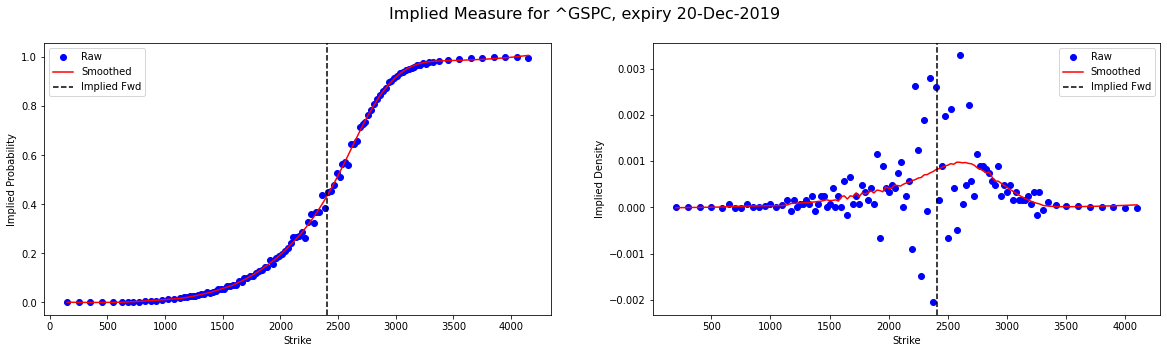

In [19]:
plot_implied_distribution(undl, expiry, fwd_hat, prob_strikes, prob, prob_hat, dens_strikes, dens, dens_hat)

The no-arbitrage intervals are linked to the existence of a well-defined risk neutral distribution and density
- Call prices are decreasing and convex in strike
- Put prices are increasing and convex in strike

# Black Scholes Model
Log-returns are assumed to be normal i.i.d. and in the absence of interim payments and fixed rates, they are governed by the SDE

$$dX_t = \left(r-\frac{\sigma^2}{2}\right)dt + \sigma dW_t$$ 

where $\sigma$ is the the annualised volatility of log-returns and $W_t$ a standard Brownian motion. Measuring returns in discrete intervals of lenght $\delta$, one obtains

$$X_t-X_{t-\delta} \sim N\left[\left(r-\frac{\sigma^2}{2}\right)\delta, \sqrt\delta\right] $$

While simplistic and unrealistic, it has become an industry standard, for reasons discussed below.

We dowload historic spot prices for SPX to test the normal i.i.d. assumption.

In [20]:
df_spot = data.DataReader(name=undl, data_source='yahoo', start='2000-01-01', end = as_of)
df_spot.tail(5)

,High,Low,Open,Close,Volume,Adj Close
Date,,,,,,
2018-12-19,2585.290039,2488.959961,2547.050049,2506.959961,5127940000,2506.959961
2018-12-20,2509.629883,2441.179932,2496.770020,2467.419922,5585780000,2467.419922
2018-12-21,2504.409912,2408.550049,2465.379883,2416.620117,7609010000,2416.620117
2018-12-24,2410.340088,2351.100098,2400.560059,2351.100098,2613930000,2351.100098
2018-12-26,2467.760010,2346.580078,2363.120117,2467.699951,4233990000,2467.699951


<AxesSubplot:xlabel='Date'>

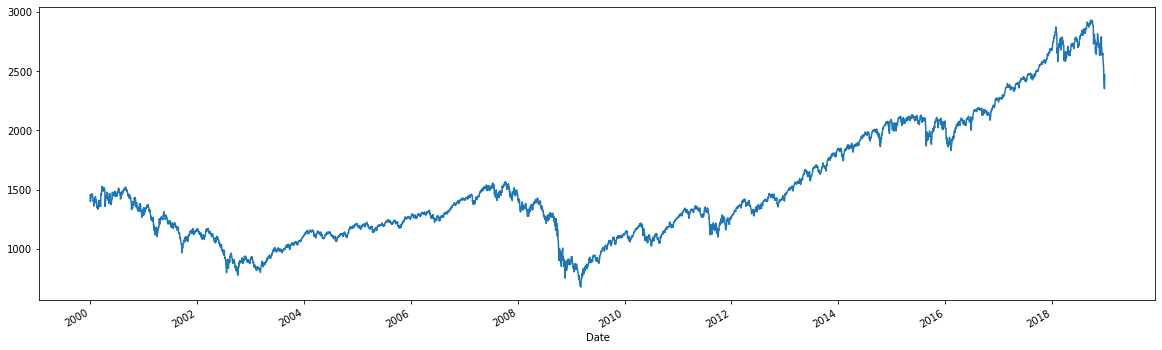

In [21]:
df_spot['Close'].plot(figsize = (20, 6))

In [22]:
def plot_log_returns_analysis(ts, undl, lag = 1, lag_title = '1D'):
    #Compute log returns and their squares
    #df_close = ts.iloc[::lag]
    df_logclose = np.log(ts.iloc[::lag])
    df_logret = (df_logclose - df_logclose.shift(1))[1:]
    df_logret_sq = df_logret**2

    #(3x2) plot
    fig, ((ax1, ax2, ax3), (ax4, ax5, ax6)) = plt.subplots(2, 3, figsize=(20,10))
    fig.suptitle(undl + ' ' + lag_title, fontsize=16)

    #(1,1) plot: histogram of log-returns vs fitted normal (with same mean & stdev)
    params = stats.norm.fit(df_logret)
    rx = np.linspace(-0.05, 0.05, 100)
    pdf_fitted = stats.norm.pdf(rx, *params)
    df_logret.plot.hist(grid=True, bins=50, density=True, ax = ax1, title = 'Histogram of LogReturns of Normal')
    ax1.plot(rx, pdf_fitted, color='r')    
    
    #(1,2) plot: log-returns time series
    df_logret.plot(ax = ax2, title = 'LogReturns')
    
    #(1,3) plot: squared log-returns time series
    df_logret_sq.plot(ax=ax3, title = 'Squared LogReturns')

    #(2,1) plot: qq-plot of log-returns vs fitted normal
    percs = np.linspace(1, 99, 99)
    qnorm = stats.norm.ppf(percs/100.0, *params)
    qsample = np.percentile(df_logret, percs)
    ax4.plot(qnorm, qsample, ls="", marker="o")
    qx = np.linspace(np.min((qnorm.min(),qsample.min())), np.max((qnorm.max(),qsample.max())))
    ax4.title.set_text('QQ of Log Returns vs Normal')
    ax4.plot(qx, qx, color="r", ls="-")
    
    #(2,2) plot: ACF of log-returns
    autocorrelation_plot(df_logret, ax=ax5)
    ax5.title.set_text('ACF LogReturns')

    #(2,3) plot: ACF of squared log-returns
    autocorrelation_plot(df_logret_sq, ax=ax6)
    ax6.title.set_text('ACF Squared LogReturns')
     
    fig.tight_layout()
    fig.subplots_adjust(top = 0.92)
    
    plt.show()

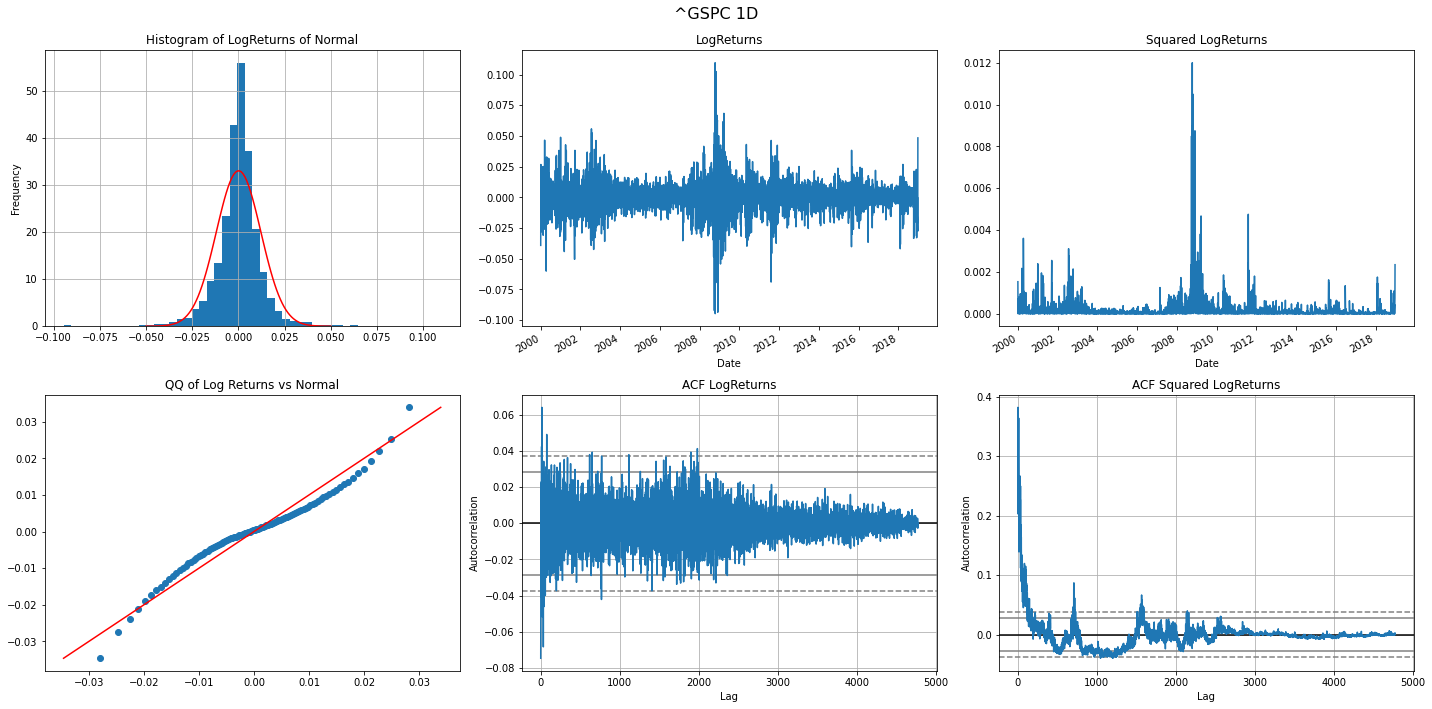

In [23]:
plot_log_returns_analysis(df_spot['Close'], undl, 1, '1D')

Log-returns deviate significantly from the normal i.i.d. paradigm.

Marginal Distribution
- Negative samples have more probability mass than the normal density
- See histogram and QQ plots

Conditional Dependence
- While levels are serially uncorrelated, the squares are not, so independence is violated
- See ACF plots

Log-returns exhibit volatility clustering.

## European Option
We begin our exploration with the closed form solution for the price of a European Call option

\begin{eqnarray}
c(S_t,t) & = & PV_t(T) \left[F_t(T) \Phi(d_1) - K \Phi(d_2) \right]\\
d_1 & = & \frac{1}{\Sigma \sqrt{T-t}} \left( \ln \left(\frac{F_t(T)}{K}\right) + \frac{\Sigma^2 (T-t)}{2} \right) \\
d_2 & = & d_1 - \Sigma \sqrt{T-t}
\end{eqnarray}

where $PV_t(T) = e^{-r(T-t)}$, $F_t(T) = PV_t^{-1}(T)S_t$ and $\Phi$ is the normal cumulative distribution function.

# Quiz 3: ATM Option Price

Interest rates are zero and there are no interim payments.

Consider a call option with expiry $T$ and strike $K=F_t(T)$. 

What is approximately its premium as a $\%$ of the forward price $F$?

1. $\Sigma \sqrt{T-t}$
4. $\Sigma^2 (T-t)$
5. Not that straightforward
6. $\frac{\Sigma \sqrt{T-t}}{\sqrt{2 \pi}}$

## No-Arbitrage Interval
The call option price $c$ as a function of volatility $\sigma$
- Achieves the lower bound for a call option price since $\lim_{\sigma \rightarrow 0} c = \max(S_t - PV_t(T) K,0)$
- Achieves the upper bound too since $\lim_{\sigma \rightarrow \infty} c = S_t$
- Is continuous and increasing

Similarly, as volatility varies in $[0, \infty)$, the put price also spans the whole no-arbitrage interval $[\max(PV_t(T)K - S_t,0), PV_t(T)K]$.

In [24]:
S = 100.0
F = S / PV
K1 = 80.0
K2 = 120.0
T = 5.0

#From vol to Price
nb_points = 100
max_vol = 3.0
vols = np.linspace(0.01, max_vol, nb_points)

c1_intrinsic = [bs_model.option_intrinsic_value(S, K1, bs_model.CALL)]*nb_points
c1_min, c1_max = bs_model.option_price_interval(S / PV, PV, K1, bs_model.CALL)
c1_min = [c1_min]*nb_points
c1_max = [c1_max]*nb_points
c1_price = bs_model.option_price(F, vols, PV, K1, T, bs_model.CALL)

p1_intrinsic = [bs_model.option_intrinsic_value(S, K2, bs_model.PUT)]*nb_points
p1_min, p1_max = bs_model.option_price_interval(S / PV, PV, K2, bs_model.PUT)
p1_min = [p1_min]*nb_points
p1_max = [p1_max]*nb_points
p1_price = bs_model.option_price(F, vols, PV, K2, T, bs_model.PUT)

#From Price to Vol
c1_prices = np.linspace(c1_min[0]+0.000001, c1_max[0]-0.000001, nb_points)
c1_vols = [bs_model.option_vol(p, F, PV, K1, T, bs_model.CALL) for p in c1_prices]

p1_prices = np.linspace(p1_min[0]+0.000001, p1_max[0]-0.000001, nb_points)
p1_vols = [bs_model.option_vol(p, F, PV, K2, T, bs_model.PUT) for p in p1_prices]

In [29]:
def plot_price_vol_mapping(spot, pv, strike1, strike2, T, vols, c1_max, c1_price, c1_min, c1_intrinsic, p1_max, p1_price, p1_min, p1_intrinsic, c1_vols, c1_prices, p1_vols, p1_prices):
    fig5, ((ax5_1, ax5_2), (ax5_3, ax5_4))  = plt.subplots(2, 2, figsize=(20,10))
    fig5.suptitle('Option Price vs Volatily', fontsize=16)

    c1_title = 'Call, Spot ' + '{:.0f}'.format(spot) + ', PV ' + '{:.2f}'.format(pv) +', Strike ' + '{:.0f}'.format(strike1) + ', Expiry ' + '{:.2f}'.format(T) +'Y'
    ax5_1.plot(vols, c1_max, label = 'Upper', color = 'b')
    ax5_1.plot(vols, c1_price, label = 'BS', color = 'g')
    ax5_1.plot(vols, c1_min, label = 'Lower', color = 'r')
    ax5_1.plot(vols, c1_intrinsic, label = 'Intrinsic', color = 'k', ls = '--')
    ax5_1.set_xlabel('Volatility')
    ax5_1.set_ylabel('Premium')
    ax5_1.set_ylim(-5.0, 120.0)
    ax5_1.fill_between(vols, c1_min, c1_max, color='grey', alpha=0.3)
    ax5_1.title.set_text(c1_title)
    ax5_1.legend()

    p1_title = 'Put, Spot ' + '{:.0f}'.format(spot) + ', PV ' + '{:.2f}'.format(pv) +', Strike ' + '{:.0f}'.format(strike2) + ', Expiry ' + '{:.2f}'.format(T) +'Y'
    ax5_2.plot(vols, p1_max, label = 'Upper', color = 'b')
    ax5_2.plot(vols, p1_price, label = 'BS', color = 'g')
    ax5_2.plot(vols, p1_min, label = 'Lower', color = 'r')
    ax5_2.plot(vols, p1_intrinsic, label = 'Intrinsic', color = 'k', ls = '--')
    ax5_2.set_xlabel('Volatility')
    ax5_2.set_ylabel('Premium')
    ax5_2.set_ylim(-5.0, 120.0)
    ax5_2.fill_between(vols, p1_min, p1_max, color='grey', alpha=0.3)
    ax5_2.title.set_text(p1_title)
    ax5_2.legend()

    #all_vols = np.linspace(0.0, max_vol, nb_points)
    #all_vols = vols

    ax5_3.plot(c1_max, vols, label = 'Upper', color = 'b')
    ax5_3.plot(c1_prices, c1_vols, label = 'IV', color = 'g')
    ax5_3.plot(c1_min, vols, label = 'Lower', color = 'r')
    ax5_3.plot(c1_intrinsic, vols, label = 'Intrinsic', color = 'k', ls = '--')
    ax5_3.set_xlabel('Premium')
    ax5_3.set_ylabel('Volatility')
    ax5_3.set_xlim(-5.0, 120.0)
    ax5_3.set_ylim(0.0, max_vol)
    ax5_3.fill_betweenx(vols, c1_min, c1_max, color='grey', alpha=0.3)
    ax5_3.title.set_text(c1_title)
    ax5_3.legend()

    ax5_4.plot(p1_max, vols, label = 'Upper', color = 'b')
    ax5_4.plot(p1_prices, p1_vols, label = 'IV', color = 'g')
    ax5_4.plot(p1_min, vols, label = 'Lower', color = 'r')
    ax5_4.plot(p1_intrinsic, vols, label = 'Intrinsic', color = 'k', ls = '--')
    ax5_4.set_xlabel('Premium')
    ax5_4.set_ylabel('Volatility')
    ax5_4.set_xlim(-5.0, 120.0)
    ax5_4.set_ylim(0.0, max_vol)
    ax5_4.fill_betweenx(vols, p1_min, p1_max, color='grey', alpha=0.3)
    ax5_4.title.set_text(p1_title)
    ax5_4.legend()

    # fig5.tight_layout()
    # fig5.subplots_adjust(top = 0.92)
    plt.show()

The monotonic and invertible price-volatility relationship is illustrated below.

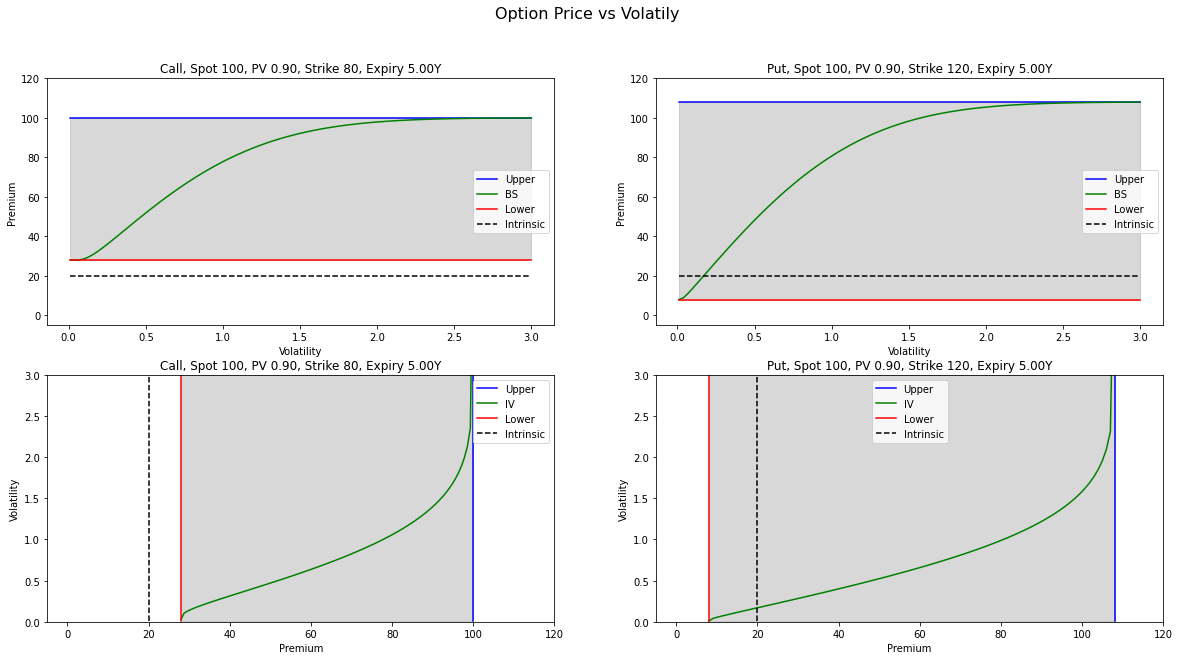

In [30]:
plot_price_vol_mapping(S, PV, K1, K2, T, vols, c1_max, c1_price, c1_min, c1_intrinsic, p1_max, p1_price, p1_min, p1_intrinsic, c1_vols, c1_prices, p1_vols, p1_prices)

For every market price $V^M$ in the no-arbitrage interval, there exists a unique volatility $\sigma^*$ that perfectly matches the price when using the BS formula - hence the term ***Implied Volatility***.

Since a) the model obeys the put-call parity by construction, b) implied volatility is a 1-1 mapping with prices and c) market quotes obey the put-call parity due to no-arbitrage, we conclude that call and put options have the same implied volatility for each $K,T$.

The existence and uniqueness of implied volatility is a major reason why the Black Scholes model has become an industry standard, despite all the empirical evidence against its assumptions. 

Implied volatility is a summary statistic for option prices, comparable to the yield for bond prices.

|Property | Implied Volatility (IV) and Option Prices | Yield (Y) and Bond Prices |
| :--- | :--- | :--- |
| No loss of information | IV is a 1-1 mapping with option prices | Y is a 1-1 mapping with bond prices |
| Normalises prices of different securities | Removes the effects of spot, strike, expiry etc. | Removes the effects of coupons, expiry etc. |
| Stationarity | IV is mean reverting, whereas option prices are not | Y is mean reverting, whereas bond prices are not |

In [33]:
def interactive_no_arb_interval(strikes6, spot6, rate6, vol6, texp6, epsilon):
    output_notebook()
    
    #Useful calculations for no-arb interval
    def no_arb_interval_chart_calcs(spot, vol, rate, strikes, texp, e):
        pv = np.exp(-rate * texp)
        fwd = spot / pv
        lb_c, ub_c = bs_model.option_price_interval(fwd, pv, strikes, bs_model.CALL)
        v_c =  bs_model.option_price(fwd, vol, pv, strikes, texp, bs_model.CALL)
        intrinsic_c = bs_model.option_intrinsic_value(spot, strikes, bs_model.CALL)    

        lb_p, ub_p = bs_model.option_price_interval(spot / pv, pv, strikes, bs_model.PUT)
        v_p =  bs_model.option_price(fwd, vol, pv, strikes, texp, bs_model.PUT)
        intrinsic_p = bs_model.option_intrinsic_value(spot, strikes, bs_model.PUT)

        x_edges = np.hstack((strikes, strikes[::-1]))
        y_edges_c = np.hstack((lb_c + e, ub_c[::-1] - e))
        y_edges_p = np.hstack((lb_p + e, ub_p[::-1] - e))

        return ((intrinsic_c, v_c, lb_c, ub_c), (intrinsic_p, v_p, lb_p, ub_p), (x_edges, y_edges_c, y_edges_p))

    ((intrinsic_c, v_c, lb_c, ub_c), (intrinsic_p, v_p, lb_p, ub_p), (x_edges, y_edges_c, y_edges_p)) = no_arb_interval_chart_calcs(spot6, vol6, rate6, strikes6, texp6, epsilon)

    #Call No-Arbitrage interval
    fig6_1 = figure(plot_width = 600, plot_height = 400, title = 'No-Arbitrage Interval, Calls', x_axis_label = 'Strike', y_axis_label = 'Price')
    l6_1_1 = fig6_1.line(strikes6, lb_c, color = 'red', line_width = 3, legend_label = 'Lower bound')
    l6_1_2 = fig6_1.line(strikes6, ub_c, color = 'blue', line_width = 3, legend_label = 'Upper bound')
    l6_1_3 = fig6_1.line(strikes6, intrinsic_c, color = 'black', line_width = 3, line_dash = 'dashed', legend_label = 'Intrinsic')
    l6_1_4 = fig6_1.line(strikes6, v_c, color = 'green', line_width = 3, legend_label = 'Price')
    source6_1 = ColumnDataSource(dict(x = x_edges, y = y_edges_c))
    glyph6_1 = Patch(x = "x", y = "y", fill_color = 'lightgrey', line_color = None, fill_alpha = 0.5)
    fig6_1.add_glyph(source6_1, glyph6_1)
    fig6_1.legend.location = "top_right"

    #Put No-Arbitrage interval
    fig6_2 = figure(plot_width = 600, plot_height = 400, title = 'No-Arbitrage Interval, Puts', x_axis_label = 'Strike', y_axis_label = 'Price')
    l6_2_1 = fig6_2.line(strikes6, lb_p, color = 'red', line_width = 3, legend_label = 'Lower bound')
    l6_2_2 = fig6_2.line(strikes6, ub_p, color = 'blue', line_width = 3, legend_label = 'Upper bound')
    l6_2_3 = fig6_2.line(strikes6, intrinsic_p, color = 'black', line_width = 3, line_dash = 'dashed', legend_label = 'Intrinsic')
    l6_2_4 = fig6_2.line(strikes6, v_p, color = 'green', line_width = 3, legend_label = 'Price')
    source6_2 = ColumnDataSource(dict(x = x_edges, y = y_edges_p))
    glyph6_2 = Patch(x = "x", y = "y", fill_color = 'lightgrey', line_color = None, fill_alpha = 0.5)
    fig6_2.add_glyph(source6_2, glyph6_2)
    fig6_2.legend.location = "top_left"

    fig6_2.x_range = fig6_1.x_range
    fig6_2.y_range = fig6_1.y_range

    #Plot charts
    s6 = show(row(fig6_1, fig6_2), notebook_handle = True)

    def no_arb_interval_chart_update(spot = spot6, vol = vol6, rate = rate6, texp = texp6):
        #pv = np.exp(-rate * texp)
        ((intrinsic_c, v_c, lb_c, ub_c), (intrinsic_p, v_p, lb_p, ub_p), (x_edges, y_edges_c, y_edges_p)) = no_arb_interval_chart_calcs(spot, vol, rate, strikes6, texp, epsilon)

        source6_1.data = {'x': x_edges, 'y': y_edges_c}
        l6_1_1.data_source.data['y'] = lb_c
        l6_1_2.data_source.data['y'] = ub_c
        l6_1_3.data_source.data['y'] = intrinsic_c
        l6_1_4.data_source.data['y'] = v_c

        source6_2.data = {'x': x_edges, 'y': y_edges_p}
        l6_2_1.data_source.data['y'] = lb_p
        l6_2_2.data_source.data['y'] = ub_p
        l6_2_3.data_source.data['y'] = intrinsic_p
        l6_2_4.data_source.data['y'] = v_p

        push_notebook(handle = s6)

    spot_slider = FloatSlider(description = 'Spot', orientation = 'horizontal', min = 50.0, max = 200.0, step = 10.0, value = spot6)
    vol_slider = FloatSlider(description = 'Vol', orientation = 'horizontal', min = 0.01, max = 5.0, step = 0.01, value = vol6)
    rate_slider = FloatSlider(description = 'Rate', orientation = 'horizontal', min = -0.05, max = 0.25, step = 0.01, value = rate6)
    texp_slider = FloatSlider(description = 'TExp', orientation = 'horizontal', min = 0.0, max = 5.0, step = 0.1, value = texp6)
    ui6_1 = VBox([spot_slider, vol_slider, rate_slider, texp_slider])
    out6_1 = interactive_output(no_arb_interval_chart_update, {'spot': spot_slider, 'vol': vol_slider, 'rate': rate_slider, 'texp': texp_slider})

    def reset_model_params_click(b):
        b.style.button_color = 'red'
        b.description = 'Resetting Params'

        spot_slider.value = spot6
        vol_slider.value = vol6
        rate_slider.value = rate6
        texp_slider.value = texp6

        b.description = 'Reset Params'
        b.style.button_color = 'lightgreen'

        return

    button6_2 = Button(description = "Reset Params", tooltip = 'Click to reset parameters to initial values')
    button6_2.style.button_color = 'lightgreen'
    button6_2.style.font_weight = 'bold'
    button6_2.on_click(reset_model_params_click)
    ui6_2 = VBox([button6_2])

    #Display widgets
    display(HBox([ui6_1, ui6_2]))    

In [34]:
interactive_no_arb_interval(np.linspace(0.01, 200.0, 100), 100.0, 0.05, 0.25, 2.0, 1.0)

Loading BokehJS ...

We draw the following conclusions

- For any configuration of $S, r, T-t$, the BS call and put option prices across different strikes span their no-arbitrage intervals as volatility varies in $[0,\infty)$, and they do so simultaneously

- For any given configuration of $S, r, T-t$ and any given market price $V^M(K_1)$, the option prices for all other strikes are pinned down completely by the model. As a consequence there is no freedom to match any other market price $V^M(K_2)$ unless it happens to trade at an identical volatility

# Implied Volatility Surface
Almost always, there is significant variation in the observed implied volatilities across strikes and expiries, and no single choise of volatility can match multiple market quotes.

Practitioners have opted for patching the Black Scholes model by using a different level of volatility for each $K,T$. We introduce the following terminology
- The collection of the implied volatilities across $K,T$ is the ***Volatility Surface*** $\Sigma(K,T)$
- The cross-section across a fixed $T$ is the ***Volatility Smile*** (or Skew)
- The cross-section across a fixed $K$ is the ***Volatility Term Structure***

In order to compute the implied volatility for each observed quoted call & put price, we invert the Black Scholes formula for each $K,T$ with $PV_t(T)$ and $F_t(T)$ set to their OLS fitted values.

We employ the analytic libraries to compute the implied volatility using a basic bisection algorithm.

In [35]:
spot_close = 2400.00
tau = (expiry - as_of)/ datetime.timedelta(days=1)/365.25

implied_vols = [bs_model.option_vol(r['Midpoint'], fwd_hat, pv_hat, r['Strike'], tau, r['Type']) for i, r in df_common.iterrows()]
df_common['IV'] = implied_vols

valid_calls = df_common[df_common['IV'].notnull() & (df_common['Type'] == 'CALL')]
valid_puts = df_common[df_common['IV'].notnull() & (df_common['Type'] == 'PUT')]

few_strikes = strikes[(strikes > 0.75 * fwd_hat) & (strikes < 1.25 * fwd_hat)]
valid_calls2 = valid_calls[valid_calls['Strike'].isin(few_strikes)]
valid_puts2 = valid_puts[valid_puts['Strike'].isin(few_strikes)]

In [36]:
def plot_implied_volatility(undl, expiry, fwd_hat, pv_hat, valid_calls, valid_calls2, valid_puts, valid_puts2):
    fig7, (ax7_1, ax7_2) = plt.subplots(1, 2, figsize=(20,5))
    fig7.suptitle('Implied Volatility for ' + undl + ', expiry ' + expiry.strftime("%d-%b-%Y"), fontsize=16)

    ax7_1.plot(valid_calls['Strike'].values, valid_calls['IV'].values, label = 'Call', ls='', marker = 'o', color = 'b')
    ax7_1.plot(valid_puts['Strike'].values, valid_puts['IV'].values, label = 'Put', ls='', marker = 'o', color = 'r')
    ax7_1.axvline(x = fwd_hat, label = 'Implied Fwd', color = 'k', ls = '--')
    ax7_1.set_xlabel('Strike')
    ax7_1.set_ylabel('Implied Volatility')
    ax7_1.legend()

    ax7_2.plot(valid_calls2['Strike'].values, valid_calls2['IV'].values, label = 'Call', ls='', marker = 'o', color = 'b')
    ax7_2.plot(valid_puts2['Strike'].values, valid_puts2['IV'].values, label = 'Put', ls='', marker = 'o', color = 'r')
    ax7_2.axvline(x = fwd_hat, label = 'Implied Fwd', color = 'k', ls = '--')
    ax7_2.set_xlabel('Strike')
    ax7_2.set_ylabel('Implied Volatility')
    ax7_2.legend()

    plt.show()    

We plot the SPX implied volatilities for the option chain.

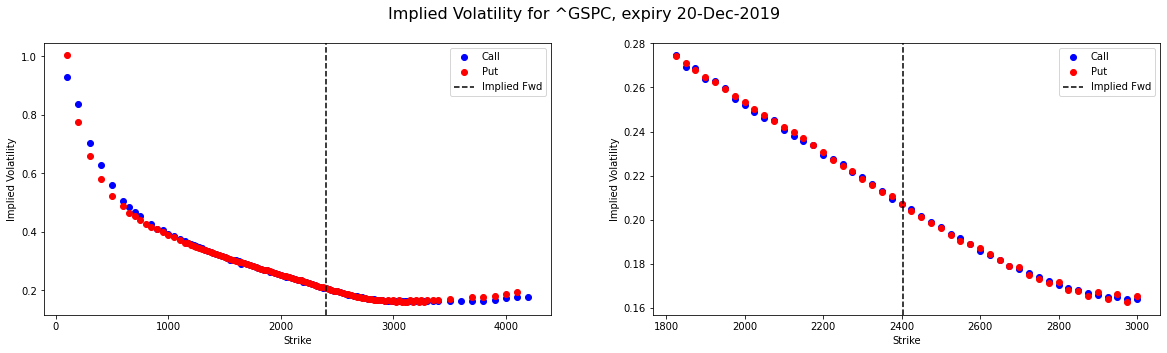

In [37]:
plot_implied_volatility(undl, expiry, fwd_hat, pv_hat, valid_calls, valid_calls2, valid_puts, valid_puts2)

This empirically validates that observed put & call options obey the put- call parity, and also share the same implied volatility for each $K,T$.

However, erroneous results are obtained when using the wrong $PV_t(T)$ or $F_t(T)$.

In [38]:
df_common_wrong = df_common.copy()

implied_vols_wrong_fwd_d = []
implied_vols_wrong_pv_d = []
implied_vols_wrong_fwd_u = []
implied_vols_wrong_pv_u = []
for i, r in df_common_wrong.iterrows():
    iv_wrong_fwd_d = bs_model.option_vol(r['Midpoint'], 0.99 * fwd_hat, pv_hat, r['Strike'], tau, r['Type'])
    iv_wrong_fwd_u = bs_model.option_vol(r['Midpoint'], 1.01 * fwd_hat, pv_hat, r['Strike'], tau, r['Type'])
    iv_wrong_pv_d = bs_model.option_vol(r['Midpoint'], fwd_hat, 0.99 * pv_hat, r['Strike'], tau, r['Type'])
    iv_wrong_pv_u = bs_model.option_vol(r['Midpoint'], fwd_hat, 1.01 * pv_hat, r['Strike'], tau, r['Type'])
    implied_vols_wrong_fwd_d.append(iv_wrong_fwd_d)
    implied_vols_wrong_fwd_u.append(iv_wrong_fwd_u)
    implied_vols_wrong_pv_d.append(iv_wrong_pv_d)
    implied_vols_wrong_pv_u.append(iv_wrong_pv_u)

df_common_wrong['IV Wrong Fwd Dn'] = implied_vols_wrong_fwd_d
df_common_wrong['IV Wrong Fwd Up'] = implied_vols_wrong_fwd_u
df_common_wrong['IV Wrong PV Dn'] = implied_vols_wrong_pv_d
df_common_wrong['IV Wrong PV Up'] = implied_vols_wrong_pv_u

calls_wrong = df_common_wrong[df_common_wrong['IV'].notnull() & (df_common_wrong['Type'] == 'CALL') & (df_common_wrong['Strike'].isin(few_strikes))]
puts_wrong = df_common_wrong[df_common_wrong['IV'].notnull() & (df_common_wrong['Type'] == 'PUT') & (df_common_wrong['Strike'].isin(few_strikes))]

In [39]:
def plot_wrong_implied_vols(undl, expiry, fwd_hat, pv_hat, calls_wrong, puts_wrong):
    fig8, ((ax8_1, ax8_2), (ax8_3, ax8_4)) = plt.subplots(2, 2, figsize=(20,10))
    fig8.suptitle('Implied Volatility for ' + undl + ', expiry ' + expiry.strftime("%d-%b-%Y"), fontsize=16)

    ax8_1.title.set_text('Wrong Forward by -1%')
    ax8_1.plot(calls_wrong['Strike'].values, calls_wrong['IV Wrong Fwd Dn'].values, label = 'Call', ls='', marker = 'o', color = 'b')
    ax8_1.plot(puts_wrong['Strike'].values, puts_wrong['IV Wrong Fwd Dn'].values, label = 'Put', ls='', marker = 'o', color = 'r')
    ax8_1.plot(puts_wrong['Strike'].values, puts_wrong['IV'].values, label = 'Market', ls='', marker = 'o', color = 'g')
    ax8_1.axvline(x = fwd_hat, label = 'Implied Fwd', color = 'k', ls = '--')
    ax8_1.set_xlabel('Strike')
    ax8_1.set_ylabel('Implied Volatility')
    ax8_1.legend()

    ax8_3.title.set_text('Wrong Forward by +1%')
    ax8_3.plot(calls_wrong['Strike'].values, calls_wrong['IV Wrong Fwd Up'].values, label = 'Call', ls='', marker = 'o', color = 'b')
    ax8_3.plot(puts_wrong['Strike'].values, puts_wrong['IV Wrong Fwd Up'].values, label = 'Put', ls='', marker = 'o', color = 'r')
    ax8_3.plot(puts_wrong['Strike'].values, puts_wrong['IV'].values, label = 'Market', ls='', marker = 'o', color = 'g')
    ax8_3.axvline(x = fwd_hat, label = 'Implied Fwd', color = 'k', ls = '--')
    ax8_3.set_xlabel('Strike')
    ax8_3.set_ylabel('Implied Volatility')
    ax8_3.legend()

    ax8_2.title.set_text('Wrong PV by -1%')
    ax8_2.plot(calls_wrong['Strike'].values, calls_wrong['IV Wrong PV Dn'].values, label = 'Call', ls='', marker = 'o', color = 'b')
    ax8_2.plot(puts_wrong['Strike'].values, puts_wrong['IV Wrong PV Dn'].values, label = 'Put', ls='', marker = 'o', color = 'r')
    ax8_2.plot(puts_wrong['Strike'].values, puts_wrong['IV'].values, label = 'Market', ls='', marker = 'o', color = 'g')
    ax8_2.axvline(x = fwd_hat, label = 'Implied Fwd', color = 'k', ls = '--')
    ax8_2.set_xlabel('Strike')
    ax8_2.set_ylabel('Implied Volatility')
    ax8_2.legend()

    ax8_4.title.set_text('Wrong PV by +1%')
    ax8_4.plot(calls_wrong['Strike'].values, calls_wrong['IV Wrong PV Up'].values, label = 'Call', ls='', marker = 'o', color = 'b')
    ax8_4.plot(puts_wrong['Strike'].values, puts_wrong['IV Wrong PV Up'].values, label = 'Put', ls='', marker = 'o', color = 'r')
    ax8_4.plot(puts_wrong['Strike'].values, puts_wrong['IV'].values, label = 'Market', ls='', marker = 'o', color = 'g')
    ax8_4.axvline(x = fwd_hat, label = 'Implied Fwd', color = 'k', ls = '--')
    ax8_4.set_xlabel('Strike')
    ax8_4.set_ylabel('Implied Volatility')
    ax8_4.legend()

    #fig8.tight_layout()
    #fig8.subplots_adjust(top = 0.92)

    plt.show()    

Put-call parity is broken due to the mis-specification of the implied forward and discount factor.

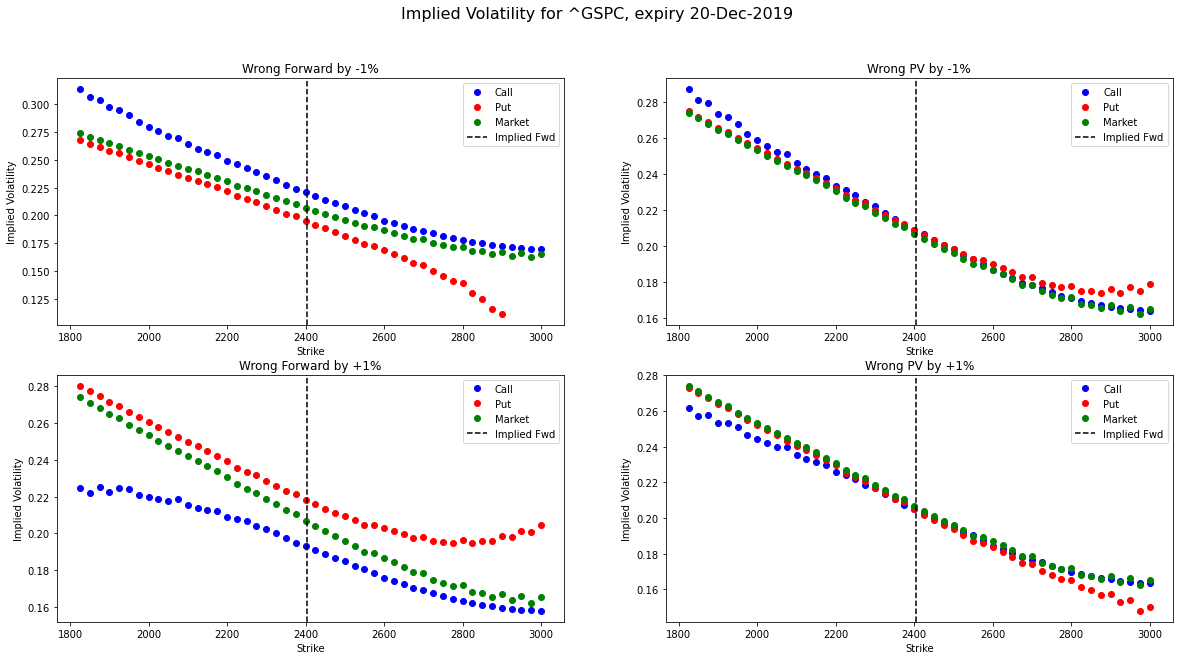

In [40]:
plot_wrong_implied_vols(undl, expiry, fwd_hat, pv_hat, calls_wrong, puts_wrong)

The observed market prices obey put-call parity at the correct levels of $PV_t(T)$ and $F_t(T)$.

- **Forward mismatch**: at a lower $F$, but fixed $PV$, call prices *should* have been cheaper, and put prices more expensive - but they are not. In fact, call prices *seem* more expensive and put prices cheaper than they should be. Hence, volatility implied from calls is erroneously higher than implied from puts, with the real implied volatility in between. The opposite effect takes place when one overestimates $F$.

- **PV mismatch**: at a lower $PV$ but fixed $F$, both call and put prices *should* have been cheaper - but they are not. In fact, both call and put prices *seem* more expensive. Hence, the implied volatilities of both calls and puts are greater than the real implied volatility. The opposite effect takes place when one overestimates $PV$.

For very deep out or in the money options, $F$ or $PV$ mismatch may result in an erroneous violation of the no-arbitrage interval, in which case an implied volatility will not exist.

## Implied Volatility Stylised Facts
The shape of the volatility surface across $K$ and $T$ varies across underlyings and market conditions
- Equity indices tend to have downward sloping implied volatility across $K$ i.e. the skew is the dominant effect. A major driver is the demand for broad insurance against a market drop; low strike puts are bid up, which then translates to higher implied volatilities. Also, equity markets tend to be more volatile during crashes, which is priced-in by the smile.
- Single stock volatility surfaces also tend to be downward sloping in $K$, but there may be idiosyncratic drivers to price-in a market rally, thus resulting in convexity. In extreme cases of positive expectations the smile may even be upward sloping e.g. M&A activity.
- FX implied volatility tends to be more symmetric in $K$ as there is natural demand for both currencies.
- In low (high) volatility environments the volatility term structure is typically upward (downward) sloping as the term structure is pricing-in some reversion to a volatility average.

# Implied Volatility Parameterisation

Only a discrete set of option prices are observable in the market, it is thus typical to parameterise volatiliy across $(K,T)$ in order to interpolate and extrapolate to unbservable points. 

The parameterisation should be rich and flexible  enough to fit the stylised facts and adapt to varying market conditions.

## Market Observables
Consider an equity option market that is liquid arount an ATM strike $K^*$ and for which we observe the implied volatility for 3 strikes, and focus on

\begin{eqnarray}
ATM & = & \Sigma^M (100\% K^*) \\
skew & = & \frac{1}{2} \left(\Sigma^M (90\% K^*) -  \Sigma^M (110\% K^*)\right) \\
convx & = & \frac{1}{2} \left(\Sigma^M (90\% K^*) - 2 \times \Sigma^M (100\% K^*) + \Sigma^M (110\% K^*) \right)
\end{eqnarray}

In this setup, ***skew*** is a measure of the slope and ***convexity*** a measure of curvature around $K^*$. In fact, both are finite difference estimates of the first and second mathematical derivatives w.r.t. strike. 


## Quadratic in Moneyness
Consider now as a starting point the quadratic
$$ q(x) = a + bx + \frac{1}{2}cx^2 $$

We define the implied volatility as a quadratic in proportional forward moneyness

\begin{eqnarray}
\Sigma_q(K) &=& q(pm(K)) \\
pm(K) &=& \frac{K - K^*}{K^*} \\
K^* &=& PV^{-1}K^{ref}
\end{eqnarray}

We have chosen the ATM strike to be the forward price of a fixed reference strike $K^{ref}$, typically the spot price of the underlying when the volatility is fitted. 

Implied volatility is a quadratic and we can link the 3 parameters to the observable points

\begin{eqnarray}
a & = & \Sigma_q(K^*) = ATM \\
b & = & \Sigma_q'(K^*) \approx skew \times 10 \\
c & = & \Sigma_q''(K^*) \approx convx \times 100
\end{eqnarray}

where the multipliers of $10$ and $100$ are due to the market observables being only the numerators of the finite difference estimates.

The parameterisation is intuitive since all parameters can be easily linked to market observables and can achieve a variety of different shapes to match the various stylised facts and market environments. 

However, once the ATM region is fit, there are no degrees of freedom left to fit the wings; these simply inherit the quadratic behaviour of the ATM region and can thus explode to $+\infty$.

## Quadratic in Generalised Moneyness
Consider a monotonic function $f$, and generalise the volatility parameterisation to

$$\Sigma_{q \bullet f}(K) = q(f(pm(K)))$$

If $f$ is such that $f(0) = 0$, $f'(0) = 1$ and $f''(0) = 0$, the quadratic is locally preserved

\begin{eqnarray}
\Sigma_{q \bullet f}(K^*) & = \Sigma_{q}(K^*) \\
\Sigma_{q \bullet f}'(K^*) & = \Sigma_{q}'(K^*) \\
\Sigma_{q \bullet f}''(K^*) & = \Sigma_{q}''(K^*)
\end{eqnarray}

Such an $f$ impacts directly the behaviour of the wings. 

In [41]:
def plot_tanh(xs, ws):
    ys = np.array([w * np.tanh(xs / w) for w in ws])
    ylins = xs

    ys = np.insert(ys, 0, ylins, axis = 0)
    ys = np.insert(ys, 0, xs, axis = 0)

    df_tanh = pd.DataFrame(ys.transpose(), columns = ['x', 'linear'] + ['w_' + str(w) for w in ws])
    df_tanh.set_index('x', inplace = True)
    df_tanh.plot(figsize=(15, 5), title = 'TANH Wing Deformation')
    plt.show()    

$$ f(x|w) = w \tanh \left( \frac{x}{w} \right), w>0$$

For high values of $w$, the deformation has minimal impact since $\lim_{w \rightarrow \infty} f(x|w) = x$. 

For low values of $w$ however, the smile devietes significantly from a quadratic at the wings.

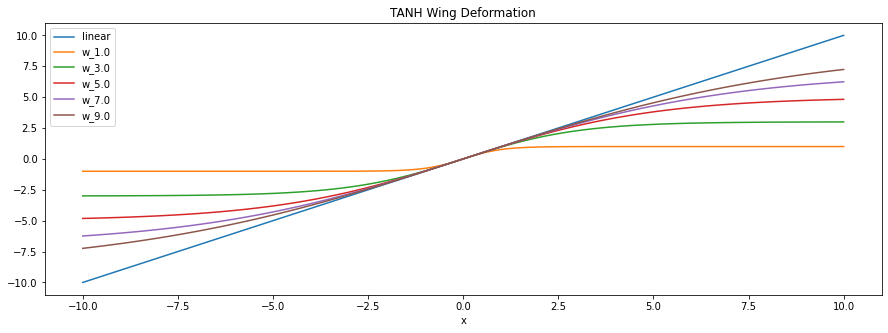

In [42]:
xs = np.linspace(-10, 10, 101)
ws = np.arange(1.0, 11.0, 2.0)

plot_tanh(xs, ws)

## Fitting & Calibration
In order to fit the volatility parameterisation to market quotes, use a typical objective function minimisation

$$\min_{a,b,c,w} \sum_{i=1}^N \left(\Sigma(K_i | a,b,c,w) - \Sigma^M(K_i) \right)^2$$

The optimal parameters provide the best fit to current market quotes and can be used to evaluate the volatility for any other strike. 

Fitting volatilities is preferrable to fitting prices, as the latter will place excessive focus on ITM prices and is unlikely to fit weel the liquid OTM contracts.

In [45]:
def interactive_vol_fitting(fwd_hat, valid_puts2, p_kref, p_a, p_b, p_c, p_w):
    output_notebook()
    
    def tanh_vol_chart_calcs(market_strikes, market_vols, kref, a, b, c, w):
        iv_calc_tanh = iv_model.IV_Quad_F(kref, a, b, c, iv_model.build_tanh_prop_moneyness(w, pv_hat))
        tanh_vols = iv_calc_tanh.implied_vol(market_strikes, 1.0)

        iv_calc_quad = iv_model.IV_Quad_F(kref, a, b, c, iv_model.build_quad_prop_moneyness(pv_hat))
        quad_vols = iv_calc_quad.implied_vol(market_strikes, 1.0)

        tanh_mse = np.sqrt(np.sum((tanh_vols - market_vols)**2)/len(market_vols))
        quad_mse = np.sqrt(np.sum((quad_vols - market_vols)**2)/len(market_vols))

        return ((tanh_vols, quad_vols), (tanh_mse, quad_mse))

    market_strikes = valid_puts2['Strike'].values
    market_vols = valid_puts2['IV'].values

    k90_idx = np.abs(market_strikes - 0.9 * fwd_hat).argmin()
    k100_idx = np.abs(market_strikes - fwd_hat).argmin()
    k110_idx = np.abs(market_strikes - 1.1 * fwd_hat).argmin()

    ((tanh_vols, quad_vols), (tanh_mse, quad_mse)) = tanh_vol_chart_calcs(market_strikes, market_vols, p_kref, p_a, p_b, p_c, p_w)

    #Smile
    #title = 'Implied Volatility Fit', 
    fig9 = figure(plot_width = 1000, plot_height = 400, x_axis_label = 'Strike', y_axis_label = 'IV')
    t9 = Title()
    t9.text = 'Implied Volatility Fit, MSE = ' + '{:.2f}'.format(100.0 * tanh_mse) + '%'
    fig9.title = t9
    c9_1 = fig9.circle(x = market_strikes, y = market_vols, color = 'green', size = 7, legend_label = 'Market')
    c9_2 = fig9.circle(x = market_strikes[[k90_idx, k100_idx, k110_idx]], y = market_vols[[k90_idx, k100_idx, k110_idx]], color = 'green', size = 15, legend_label = 'Market')
    l9_1 = fig9.line(market_strikes, tanh_vols, color = 'blue', line_width = 3, legend_label = 'TANH Model')
    l9_2 = fig9.line(market_strikes, quad_vols, color = 'red', line_width = 3, legend_label = 'QUAD Model')
    vline9_1 = Span(location = p_kref, dimension = 'height', line_color = 'blue', line_width=1, line_dash = 'dashed')
    vline9_2 = Span(location = fwd_hat, dimension = 'height', line_color = 'green', line_width=1, line_dash = 'dashed')
    vline9_3 = Span(location = market_strikes[k90_idx], dimension = 'height', line_color = 'green', line_width=1, line_dash = 'dashed')
    vline9_4 = Span(location = market_strikes[k110_idx], dimension = 'height', line_color = 'green', line_width=1, line_dash = 'dashed')
    hline9_1 = Span(location = market_vols[k90_idx], dimension = 'width', line_color = 'green', line_width=1, line_dash = 'dashed')
    hline9_2 = Span(location = market_vols[k110_idx], dimension = 'width', line_color = 'green', line_width=1, line_dash = 'dashed')
    hline9_3 = Span(location = market_vols[k100_idx], dimension = 'width', line_color = 'green', line_width=1, line_dash = 'dashed')
    fig9.legend.location = "top_right"
    #fig9.add_tools(HoverTool( tooltips = [( 'Market', '@Market{F}'), ( 'TANH Model', '@{TANH Model}{%0.2f}'), ( 'QUAD Model', '@{QUAD Model}{%0.2f}')], mode = 'vline'))
    fig9.add_tools(CrosshairTool())

    fig9.renderers.extend([vline9_1, vline9_2, vline9_3, vline9_4, hline9_1, hline9_2, hline9_3])
    
    #Plot charts
    s9 = show(fig9, notebook_handle = True)

    #fig9.renderers.extend([vline9_1, vline9_2, vline9_3, vline9_4])

    def tanh_vol_chart_update(kref = p_kref, a = p_a, b = p_b, c = p_c, w = p_w):
        ((tanh_vols, quad_vols), (tanh_mse, quad_mse)) = tanh_vol_chart_calcs(market_strikes, market_vols, kref, a, b, c, w)

        l9_1.data_source.data['y'] = tanh_vols
        l9_2.data_source.data['y'] = quad_vols
        vline9_1.location = kref
        t9.text = 'Implied Volatility Fit, MSE = ' + '{:.2f}'.format(100.0 * tanh_mse) + '%'

        push_notebook(handle = s9)
        return


    kref_slider = FloatSlider(description = 'KRef', orientation = 'horizontal', min = market_strikes[0], max = market_strikes[-1], step = 10.0, value = p_kref)
    a_slider = FloatSlider(description = 'a', orientation = 'horizontal', min = np.nanmin(market_vols), max = np.nanmax(market_vols), step = 0.001, value = p_a)
    b_slider = FloatSlider(description = 'b', orientation = 'horizontal', min = -0.5, max = 0.5, step = 0.01, value = p_b)
    c_slider = FloatSlider(description = 'c', orientation = 'horizontal', min = -1.0, max = 1.0, step = 0.05, value = p_c)
    w_slider = FloatSlider(description = 'w', orientation = 'horizontal', min = 0.01, max = 2.0, step = 0.05, value = p_w)
    ui9_1 = VBox([kref_slider, a_slider, b_slider, c_slider, w_slider])
    out9_1 = interactive_output(tanh_vol_chart_update, {'kref': kref_slider, 'a': a_slider, 'b': b_slider, 'c': c_slider, 'w': w_slider})

    #display(ui9_1, out9_1)

    #wdgt9 = interact(tanh_vol_chart_update, kref = kref_slider, a = a_slider, b = b_slider, c = c_slider, w = w_slider)

    def build_tanh_objective_function(market_strikes, market_vols, kref):
        def objective_function(params):
            a = params[0],
            b = params[1]
            c = params[2]
            w = params[3]
            tanh_mse = tanh_vol_chart_calcs(market_strikes, market_vols, kref, a, b, c, w)[1][0]
            return tanh_mse
        return objective_function

    def tanh_optimize_click(b):
        b.style.button_color = 'red'
        b.description = 'Optimizing'

        try:
            obj_func = build_tanh_objective_function(market_strikes, market_vols, kref_slider.value)
            res = optimize.minimize(obj_func, np.asarray([a_slider.value, b_slider.value, c_slider.value, w_slider.value]))
            if res.success:
                a_slider.value = res.x[0]
                b_slider.value = res.x[1]
                c_slider.value = res.x[2]
                w_slider.value = res.x[3]
            b.description = 'Optimize'
            b.style.button_color = 'lightgreen'
        except:
            b.description = 'Optimize'
            b.style.button_color = 'lightgreen'

        return

    button9_1 = Button(description = "Optimize", tooltip = 'Click to fit functional form to market levels')
    button9_1.style.button_color = 'lightgreen'
    button9_1.style.font_weight = 'bold'
    button9_1.on_click(tanh_optimize_click)

    def reset_fwd_click(b):
        b.style.button_color = 'red'
        b.description = 'Resetting KRef'

        kref_slider.value = p_kref

        b.description = 'Reset KRef'
        b.style.button_color = 'lightgreen'

        return

    button9_2 = Button(description = "Reset KRef", tooltip = 'Click to reset to market implied forward')
    button9_2.style.button_color = 'lightgreen'
    button9_2.style.font_weight = 'bold'
    button9_2.on_click(reset_fwd_click)

    def reset_params_click(b):
        b.style.button_color = 'red'
        b.description = 'Resetting Params'

        kref_slider.value = p_kref
        a_slider.value = p_a
        b_slider.value = p_b
        c_slider.value = p_c
        w_slider.value = p_w

        b.description = 'Reset Params'
        b.style.button_color = 'lightgreen'

        return

    button9_3 = Button(description = "Reset Params", tooltip = 'Click to reset parameters to initial values')
    button9_3.style.button_color = 'lightgreen'
    button9_3.style.font_weight = 'bold'
    button9_3.on_click(reset_params_click)
    ui9_2 = VBox([button9_1, button9_2, button9_3])

    #Display widgets
    display(HBox([ui9_1, ui9_2]))    

We now fit this functional form to SPX implied volatilities.

In [46]:
interactive_vol_fitting(fwd_hat, valid_puts2, fwd_hat, 0.23, -0.15, 0.01, 0.1)

Loading BokehJS ...

## No-Arbitrage Revisited

A functional form for implied volatility is not a model. It is a description of market prices via the operational definition $p(K) = BS(K, \Sigma(K))$.

When rates are zero, the implied probability distribution is given by

$$
Q = \frac{dp}{dK} = \frac{\partial BS}{\partial K} + \frac{\partial BS}{\partial \Sigma} \frac{d\Sigma}{dK}
$$

The first term is the model-based LogNormal distribution. The second term is the adjustment due to the volatility smile, and an ill-behaved functional form could result in $Q \not \in [0,1]$. Extrapolating too much skew $\tfrac{d\Sigma}{dK}$, or oscillations when interpolating, can make the second term dominate. 

Similar comments apply for the implied density when computing $q=\tfrac{d^2p}{dK^2}$.

In [47]:
def interactive_smile_density(strikes, p_T, p_S, p_PV, p_kref, p_a, p_b, p_c, p_w):
    output_notebook()
    
    def implied_distribution_tanh_calc(T, spot, PV, KRef, a, b, c, w):
        iv_calc = iv_model.IV_Quad_F(KRef, a, b, c, iv_model.build_tanh_prop_moneyness(w, PV))
        return iv_model.implied_distribution(strikes, T, spot, PV, iv_calc)

    vols, v, dist, dens = implied_distribution_tanh_calc(p_T, p_S, p_PV, p_kref, p_a, p_b, p_c, p_w)
    vols0, v0, dist0, dens0 = implied_distribution_tanh_calc(p_T, p_S, p_PV, p_kref, p_a, 0.0, 0.0, 1.0)

    #x_axis = np.log(strikes * p_PV / p_S)
    x_axis = strikes

    width = 700
    height = 300

    fig1 = figure(plot_width = width, plot_height = height, x_axis_label = 'Strike', y_axis_label = 'Implied Volatility')
    src1 = ColumnDataSource(data={'Strike': x_axis, 'IV Smile': vols, 'IV Flat': vols0})
    l1_1 = fig1.line(x = 'Strike', y = 'IV Smile', color = 'blue', line_width = 3, legend_label = 'Smile', source = src1)
    l1_2 = fig1.line(x = 'Strike', y = 'IV Flat', color = 'red', line_width = 3, legend_label = 'Flat', source = src1)
    v1_1 = Span(location = p_kref / p_PV, dimension = 'height', line_color = 'blue', line_width=1, line_dash = 'dashed')
    v1_2 = Span(location = p_S / p_PV, dimension = 'height', line_color = 'green', line_width=1, line_dash = 'dashed')
    fig1.renderers.extend([v1_1, v1_2])
    fig1.add_tools(HoverTool( tooltips = [( 'Strike', '@Strike{F}'), ( 'Smile', '@{IV Smile}{%0.2f}'), ( 'Flat', '@{IV Flat}{%0.2f}')], mode = 'vline'))
    #fig1.add_tools(CrosshairTool())

    fig2 = figure(plot_width = width, plot_height = height, x_axis_label = 'Strike', y_axis_label = 'Price')
    src2 = ColumnDataSource(data={'Strike': x_axis, 'Price Smile': v, 'Price Flat': v0})
    l2_1 = fig2.line(x = 'Strike', y = 'Price Smile', color = 'blue', line_width = 3, legend_label = 'Smile', source = src2)
    l2_2 = fig2.line(x = 'Strike', y = 'Price Flat', color = 'red', line_width = 3, legend_label = 'Flat', source = src2)
    v2_1 = Span(location = p_kref / p_PV, dimension = 'height', line_color = 'blue', line_width=1, line_dash = 'dashed')
    v2_2 = Span(location = p_S / p_PV, dimension = 'height', line_color = 'green', line_width=1, line_dash = 'dashed')
    fig2.renderers.extend([v2_1, v2_2])
    fig2.add_tools(HoverTool( tooltips = [( 'Strike', '@Strike{F}'), ( 'Smile', '@{Price Smile}{0.2f}'), ( 'Flat', '@{Price Flat}{0.2f}')], mode = 'vline'))


    fig3 = figure(plot_width = width, plot_height = height, x_axis_label = 'Strike', y_axis_label = 'Distribution')
    src3 = ColumnDataSource(data={'Strike': x_axis, 'Dist Smile': dist, 'Dist Flat': dist0})
    l3_1 = fig3.line(x = 'Strike', y = 'Dist Smile', color = 'blue', line_width = 3, legend_label = 'Smile', source = src3)
    l3_2 = fig3.line(x = 'Strike', y = 'Dist Flat', color = 'red', line_width = 3, legend_label = 'Flat', source = src3)
    v3_1 = Span(location = p_kref / p_PV, dimension = 'height', line_color = 'blue', line_width=1, line_dash = 'dashed')
    v3_2 = Span(location = p_S / p_PV, dimension = 'height', line_color = 'green', line_width=1, line_dash = 'dashed')
    fig3.renderers.extend([v3_1, v3_2])
    fig3.add_tools(HoverTool( tooltips = [( 'Strike', '@Strike{F}'), ( 'Dist Smile', '@{Dist Smile}{%0.2f}'), ( 'Dist Flat', '@{Dist Flat}{%0.2f}')], mode = 'vline'))
    fig3.legend.location = "top_left"

    fig4 = figure(plot_width = width, plot_height = height, x_axis_label = 'Strike', y_axis_label = 'Density')
    src4 = ColumnDataSource(data={'Strike': x_axis, 'Dens Smile': dens, 'Dens Flat': dens0})
    l4_1 = fig4.line(x = 'Strike', y = 'Dens Smile', color = 'blue', line_width = 3, legend_label = 'Smile', source = src4)
    l4_2 = fig4.line(x = 'Strike', y = 'Dens Flat', color = 'red', line_width = 3, legend_label = 'Flat', source = src4)
    v4_1 = Span(location = p_kref / p_PV, dimension = 'height', line_color = 'blue', line_width=1, line_dash = 'dashed')
    v4_2 = Span(location = p_S / p_PV, dimension = 'height', line_color = 'green', line_width=1, line_dash = 'dashed')
    fig4.renderers.extend([v4_1, v4_2])
    fig4.add_tools(HoverTool( tooltips = [( 'Strike', '@Strike{F}'), ( 'Dens Smile', '@{Dens Smile}{0.4f}'), ( 'Dens Flat', '@{Dens Flat}{0.4f}')], mode = 'vline'))

    fig1.x_range = fig2.x_range = fig3.x_range = fig4.x_range

    #Plot Charts
    s10 = show(column(row(fig1, fig2), row(fig3, fig4)), notebook_handle = True)

    def implied_distribution_tanh_update(T, spot, PV, KRef, a, b, c, w):
        vols, v, dist, dens = implied_distribution_tanh_calc(T, spot, PV, KRef, a, b, c, w)
        vols0, v0, dist0, dens0 = implied_distribution_tanh_calc(T, spot, PV, KRef, a, 0.0, 0.0, 1.0)

        new_src1 = ColumnDataSource(data={'Strike': x_axis, 'IV Smile': vols, 'IV Flat': vols0})
        new_src2 = ColumnDataSource(data={'Strike': x_axis, 'Price Smile': v, 'Price Flat': v0})
        new_src3 = ColumnDataSource(data={'Strike': x_axis, 'Dist Smile': dist, 'Dist Flat': dist0})
        new_src4 = ColumnDataSource(data={'Strike': x_axis, 'Dens Smile': dens, 'Dens Flat': dens0})

        src1.data.update(new_src1.data)
        src2.data.update(new_src2.data)
        src3.data.update(new_src3.data)
        src4.data.update(new_src4.data)

        v1_1.location = v2_1.location = v3_1.location = v4_1.location = KRef / PV
        v1_2.location = v2_2.location = v3_2.location = v4_2.location = spot / PV

        push_notebook(handle = s10)
        return

    T_slider = FloatSlider(description = 'T', orientation = 'horizontal', min = 0.01, max = 5.0, step = 0.01, value = p_T)
    S_slider = FloatSlider(description = 'S', orientation = 'horizontal', min = strikes[0], max = strikes[-1], step = 10.0, value = p_S)
    PV_slider = FloatSlider(description = 'PV', orientation = 'horizontal', min = 0.01, max = 1.5, step = 0.01, value = p_PV)
    sync_box = Checkbox(value = True, description='Sync KRef with S')#, disabled = False)
    kref_slider = FloatSlider(description = 'KRef', orientation = 'horizontal', min = strikes[0], max = strikes[-1], step = 10.0, value = p_kref)
    a_slider = FloatSlider(description = 'a', orientation = 'horizontal', min = 0.01, max = 0.5, step = 0.001, value = p_a)
    b_slider = FloatSlider(description = 'b', orientation = 'horizontal', min = -0.5, max = 0.5, step = 0.01, value = p_b)
    c_slider = FloatSlider(description = 'c', orientation = 'horizontal', min = -1.0, max = 1.0, step = 0.05, value = p_c)
    w_slider = FloatSlider(description = 'w', orientation = 'horizontal', min = 0.01, max = 2.0, step = 0.05, value = p_w)

    #lnk = link((S_slider, 'value'), (kref_slider, 'value'))
    lnk = None

    def sync_kref_with_spot(v):
        global lnk

        if(v is True):
            lnk = link((S_slider, 'value'), (kref_slider, 'value'))
        else:
            if lnk is not None:
                lnk.unlink()

        push_notebook(handle = s)
        return
    
    def reset_model_params_click(b):
        b.style.button_color = 'red'
        b.description = 'Resetting Params'

        S_slider.value = p_S
        PV_slider.value = p_PV
        T_slider.value = p_T
        kref_slider.value = p_kref
        a_slider.value = p_a
        b_slider.value = p_b
        c_slider.vale = p_c
        w_slider.value = p_w
        sync_box.value = True

        b.description = 'Reset Params'
        b.style.button_color = 'lightgreen'

        return

    button = Button(description = "Reset Params", tooltip = 'Click to reset parameters to initial values')
    button.style.button_color = 'lightgreen'
    button.style.font_weight = 'bold'
    button.on_click(reset_model_params_click)
    #ui6_2 = VBox([button6_2])

    out2 = interactive_output(sync_kref_with_spot, {'v': sync_box}) 

    ui1 = HBox([S_slider, PV_slider, T_slider, sync_box, button])
    ui2 = HBox([kref_slider, a_slider, b_slider, c_slider, w_slider])
    ui = VBox([ui1, ui2])
    out = interactive_output(implied_distribution_tanh_update, {'T': T_slider, 'spot': S_slider, 'PV': PV_slider, 'KRef': kref_slider, 'a': a_slider, 'b': b_slider, 'c': c_slider, 'w': w_slider})

    #Plot widgets
    display(HBox([ui]))

In [48]:
interactive_smile_density(np.arange(10.0, 200.0, 1.0) * fwd_hat / 100.0, 1.0, fwd_hat, pv_hat, fwd_hat, 0.20, -0.26, 0.72, 0.33)

Loading BokehJS ...

# Implied Vs Realised Volatility

Assume the realised volatility of asset prices is $\sigma$ so that $dS = \sigma S dW$.

Assume implied volatility is $\Sigma \neq \sigma$, so the option price $V(S,t)$ follows the PDE

$$
V_t + \tfrac{1}{2} V_{SS} \Sigma^2 S^2 = 0 
$$

The dynamics of the option price are governed by the SDE, obtained via Ito's lemma

$$
dV = V_t dt + V_S dS + \frac{1}{2} V_{SS} \sigma^2 S^2 dt
$$

Thus a delta-hedged option portfolio $d\Pi = dV - V_S dS$ is governed by

$$
d\Pi = \frac{1}{2} V_{SS} \left(\sigma^2 - \Sigma^2 \right) S^2 dt
$$

# Quiz 4: Monetising Implied Volatility

Implied volatility $\Sigma$ exceeds realised volatility $\sigma$.

Select the correct statement.

1. Delta-hedging long calls is a profitable strategy.

2. Delta-hedging short call spreads results in profits when spot is high.

3. Delta-hedging short put options accrues a positive constant daily profit.

4. Delta-hedging short call options accrues a positive stochastic daily profit.

# Thank you for your attention!